In [1]:
import jax
import gymnax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini.callbacks import get_null
from rebayes_mini.methods import low_rank_last_layer as flores

In [2]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

## Could you learn?

In [4]:
class CNN(nn.Module):
    num_actions: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_actions, name="last_layer")(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()

model = CNN(num_actions=10)

## Setup environment

In [5]:
key = jax.random.PRNGKey(3141)

key_env, key_env_step, key_act, key_init_params, key_run = jax.random.split(key, 5)

params_init = model.init(key_init_params, jnp.ones((28, 28, 1)))

# Initialise

In [6]:
# Instantiate the environment & its settings.
env, env_params = gymnax.make("MNISTBandit-bsuite")

# Reset the environment.
context, state = env.reset(key_env, env_params)

# Initialise agent
params_init = model.init(key_init_params, context[..., None])

# Sample a random action.
action = env.action_space(env_params).sample(key_act)

context_init, state_init, reward, done, _ = env.step(key_env_step, state, action, env_params)

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


## Online learning: full information setting

In [7]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    mean = jax.nn.softmax(eta)
    return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [8]:
new_mapping = jax.random.choice(key, 10, (10,), replace=False).astype(jnp.uint8)
new_mapping

Array([8, 4, 2, 0, 3, 7, 6, 9, 1, 5], dtype=uint8)

In [817]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Obtain reward
    label_truth = env_state.correct_label
    # label_truth = jax.lax.cond(
    #     t < 10_000, # Permute label after 20_000
    #     lambda: label_truth,
    #     lambda: new_mapping[label_truth]
    # )
    y = jax.nn.one_hot(label_truth, 10)

    # Update belief
    action = agent.mean_fn(bel.mean_hidden, bel.mean_last, context[..., None]).argmax()
    bel_update = agent.update(bel, y, context[..., None])

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (y, reward)

In [818]:
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)

In [14]:
%%time
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)
steps = 40_000

state_final, (actions, rewards_fullinfo) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_fullinfo = jax.block_until_ready(rewards_fullinfo)
rewards_fullinfo = (rewards_fullinfo + 1) / 2

CPU times: user 19.8 s, sys: 1.17 s, total: 21 s
Wall time: 59.8 s


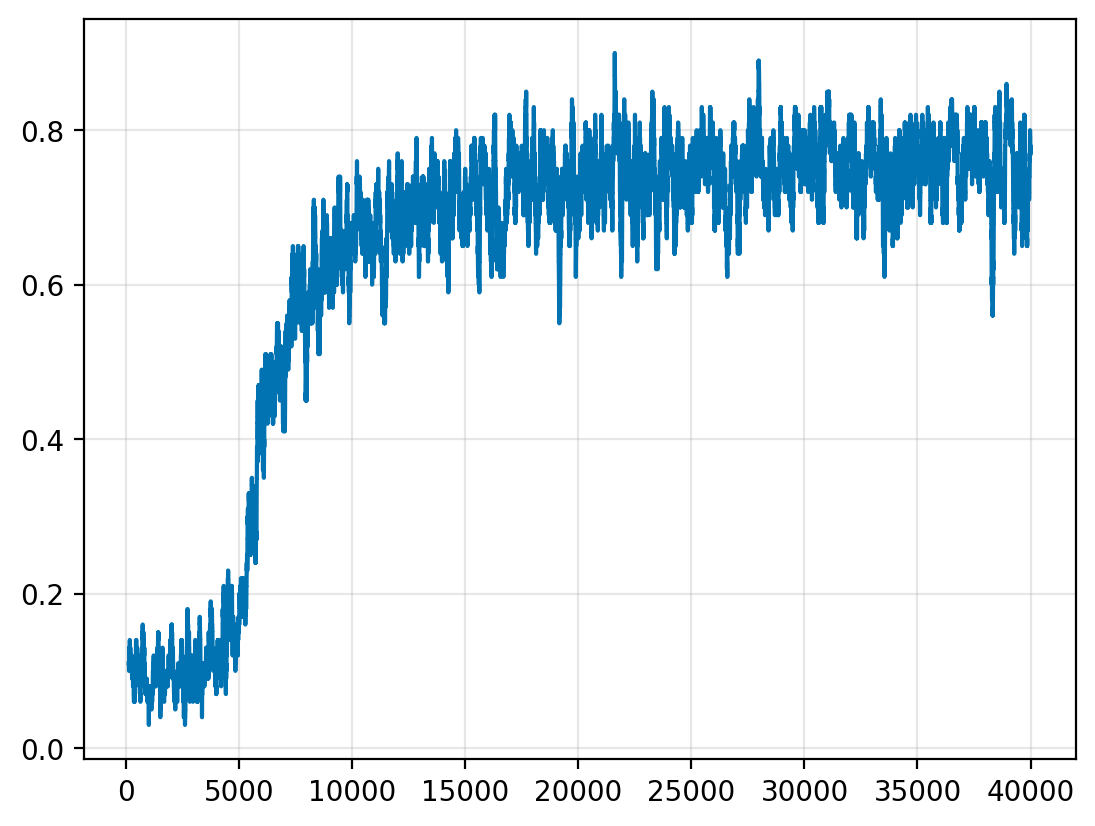

In [16]:
pd.Series(rewards_fullinfo).rolling(100).mean().plot()
plt.grid(alpha=0.3)

# Partial information

## OnFlow: $\epsilon$-greedy

In [135]:
import optax
from rebayes_mini.methods import replay_sgd
from vbll_fifo import  FifoLaplaceDiag
from jax.flatten_util import ravel_pytree
from rebayes_mini.methods import low_rank_filter as lofi
from rebayes_mini.methods import low_rank_filter_revised as lrkf

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [136]:
eps = 0.05
def step(state, t, agent, key_base):
    key_step = jax.random.fold_in(key_base, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state

    # Take action
    key_eps, key_take = jax.random.split(key_take)
    yhat = agent.predict_fn(bel, context.ravel())
    action = yhat.argmax()
    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, 10)

    action = action * (1 - take_random) + action_random * take_random
    action = action.astype(int)
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    # X = (action, context[..., None])
    X = jnp.concat([jnp.array([action]), context.ravel()])
    bel_update = agent.update(bel, y, X)

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [137]:
def mean_fn(params, x):
    x = jnp.atleast_2d(x)
    n_in = len(x[0].ravel())
    if n_in == 28 ** 2 + 1:
        # Passing context and action
        action = x[:, 0].astype(int)
        x = x[:, 1:].reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    elif n_in == 28 ** 2:
        # Passing context only
        x = x.reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        return eta
    else:
        raise ValueError("Undefined input dimension")

In [138]:
def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(jnp.atleast_1d(eta))
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [840]:
%%time
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)

_step = partial(step, agent=agent, key_base=key_run)
state_final, (actions, rewards_flores) = jax.lax.scan(_step, u_init, jnp.arange(steps))
rewards_flores = jax.block_until_ready((rewards_flores + 1) / 2)

CPU times: user 14.4 s, sys: 398 ms, total: 14.8 s
Wall time: 54.2 s


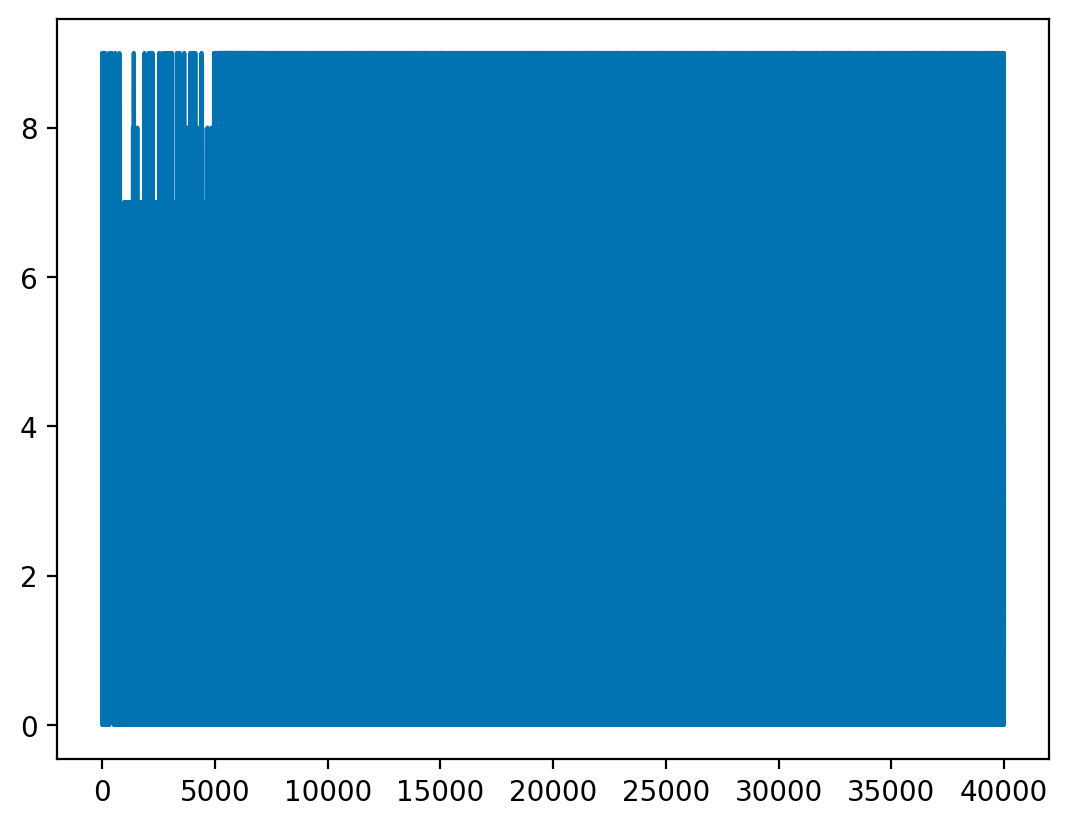

In [841]:
plt.plot(actions)

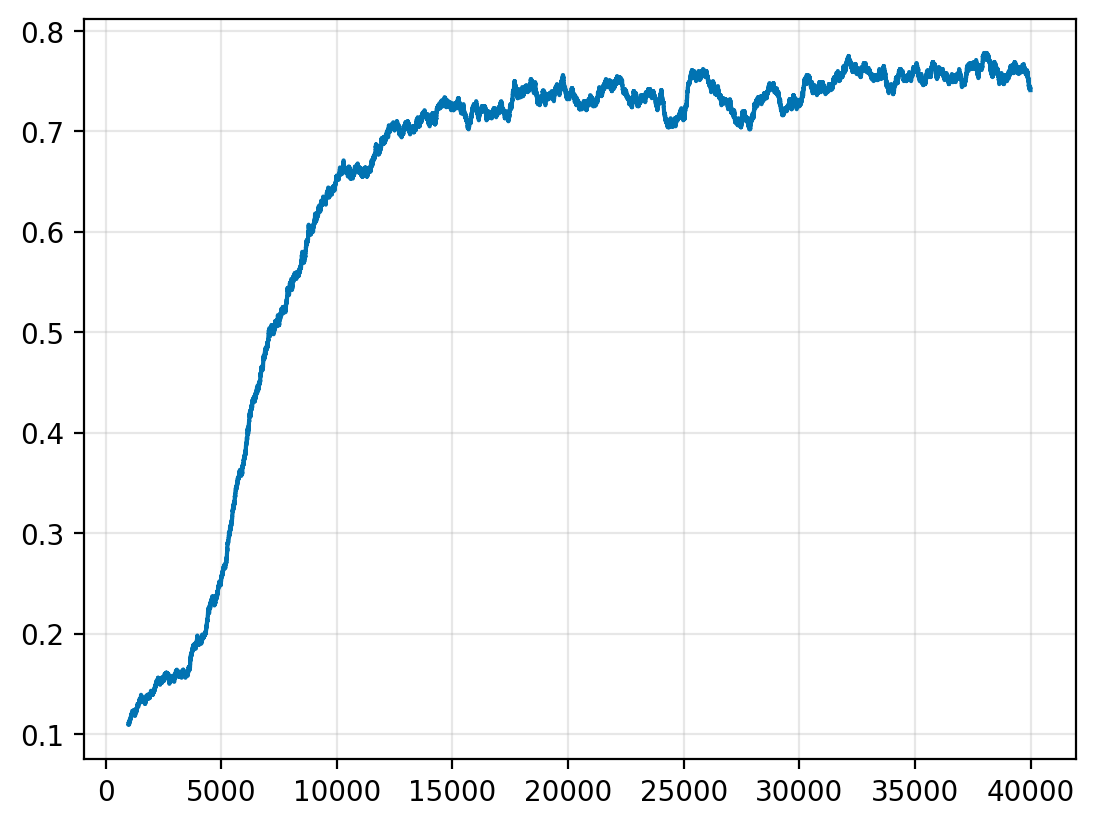

In [836]:
pd.Series(rewards_flores).rolling(1000).mean().plot()
plt.grid(alpha=0.3)

In [844]:
rewards_flores.sum()

Array(25546., dtype=float32)

## LRKF $\epsilon$-greedy

In [773]:
%%time
agent = lrkf.LowRankCovarianceFilter(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_covariance=1e-3
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov=1.0)
u_init = (bel_init, context_init, state_init)

_step = partial(step, agent=agent, key_base=key_run)
(bel_final, _, _), (actions, rewards_lrkf) = jax.lax.scan(_step, u_init, jnp.arange(steps))
rewards_lrkf = jax.block_until_ready((rewards_lrkf + 1) / 2)

CPU times: user 9.38 s, sys: 357 ms, total: 9.73 s
Wall time: 17.8 s


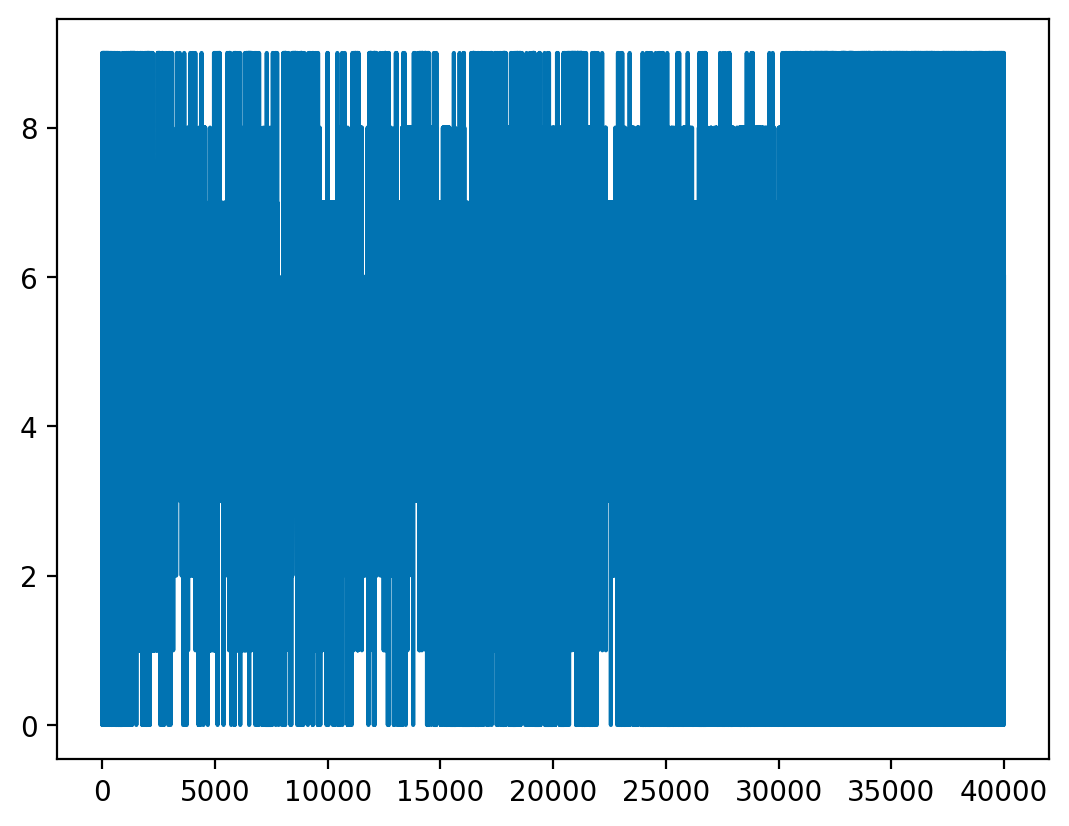

In [774]:
plt.plot(actions)

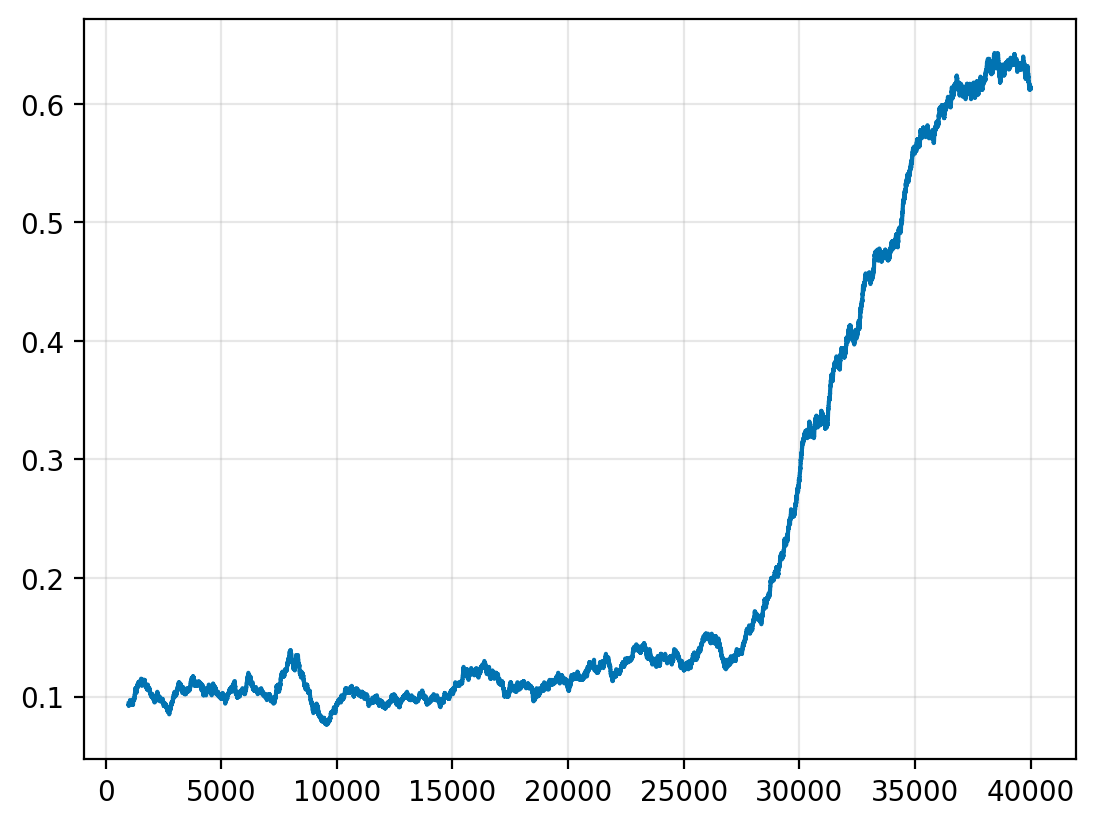

In [775]:
pd.Series(rewards_lrkf).rolling(1000).mean().plot()
plt.grid(alpha=0.3)

## LoFi

In [776]:
%%time
dynamics = 1e-3
agent = lofi.LowRankPrecisionFilter(
    mean_fn, cov_fn, dynamics_covariance=dynamics, rank=50
)

bel_init = agent.init_bel(params_init, cov=1.0)
u_init = (bel_init, context_init, state_init)

_step = partial(step, agent=agent, key_base=key_run)
(bel_final, _, _), (actions, rewards_lofi) = jax.lax.scan(_step, u_init, jnp.arange(steps))
rewards_lofi = jax.block_until_ready((rewards_lofi + 1) / 2)

CPU times: user 11 s, sys: 279 ms, total: 11.3 s
Wall time: 30.9 s


In [777]:
bel_final.mean

Array([-0.17290603, -0.08120929, -0.2849816 , ..., -0.01668348,
        0.00644208, -0.09377632], dtype=float32)

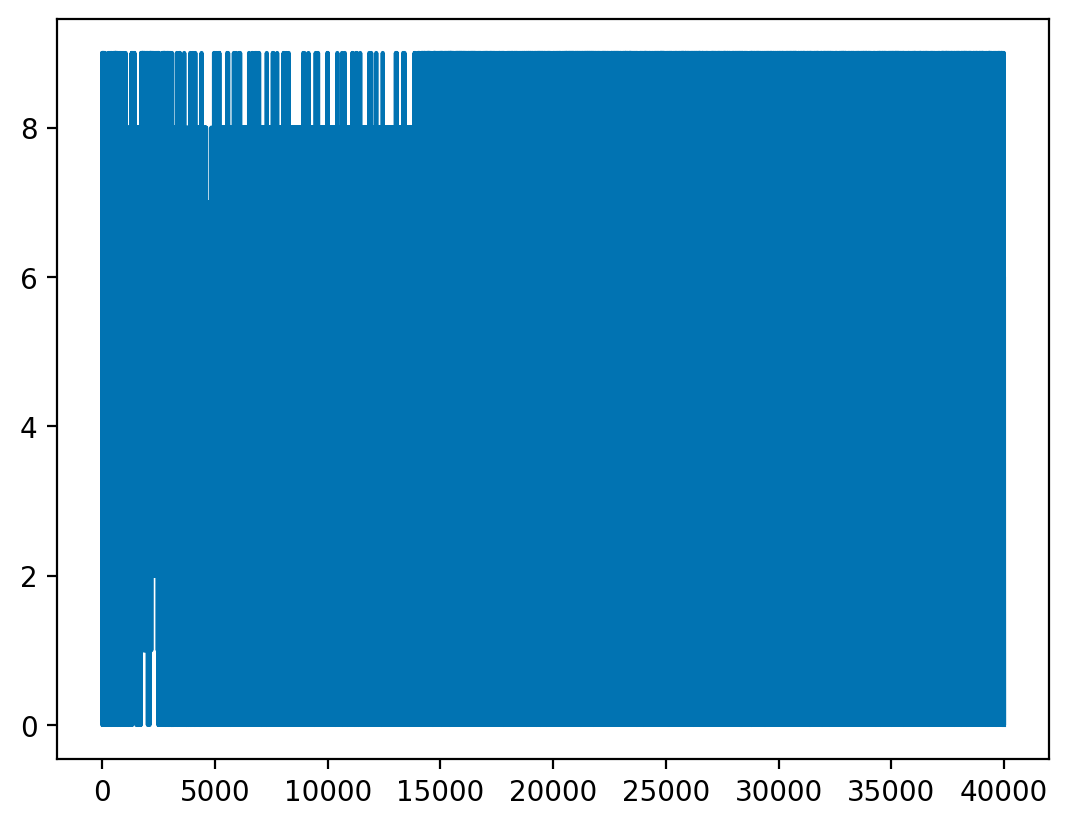

In [778]:
plt.plot(actions)

## Implicit filtering (sgd)

In [809]:
def lossfn(params, counter, x, y, apply_fn, noise=0.1):
    x = jnp.atleast_2d(x)
    action = x[:, 0].astype(int)
    x = x[:, 1:].reshape(-1, 28, 28, 1)
    res = apply_fn(params, x)

    params_flat, _ = ravel_pytree(params)
    
    yhat = jnp.take_along_axis(jnp.atleast_2d(res), action[:, None], axis=-1).squeeze()
    yhat = jax.nn.sigmoid(yhat)
    y = y.squeeze()

    log_likelihood = y * jnp.log(yhat) + (1 - y) * jnp.log1p(-yhat)
    log_likelihood = (log_likelihood * counter).sum() / counter.sum()
    return -log_likelihood #+ 0.1 * jnp.power(params_flat, 2).mean()


# learning_rate = 1e-4
buffer_size = 1
n_inner = 5
agent = FifoLaplaceDiag(
    mean_fn_ll,
    lossfn,
    tx=optax.adamw(learning_rate),
    # tx=optax.contrib.muon(learning_rate),
    buffer_size=buffer_size,
    # dim_features=(28, 28, 1),
    dim_features = 28 ** 2 + 1,
    dim_output=1,
    n_inner=n_inner,
)

In [810]:
%%time
bel_init = agent.init_bel(params_init)
u_init = (bel_init, context_init, state_init)

_step = partial(step, agent=agent, key_base=key_run)
state_final, (actions, rewards_lll) = jax.lax.scan(_step, u_init, jnp.arange(steps))
rewards_lll = jax.block_until_ready((rewards_lll + 1) / 2)

CPU times: user 6.97 s, sys: 335 ms, total: 7.3 s
Wall time: 22.8 s


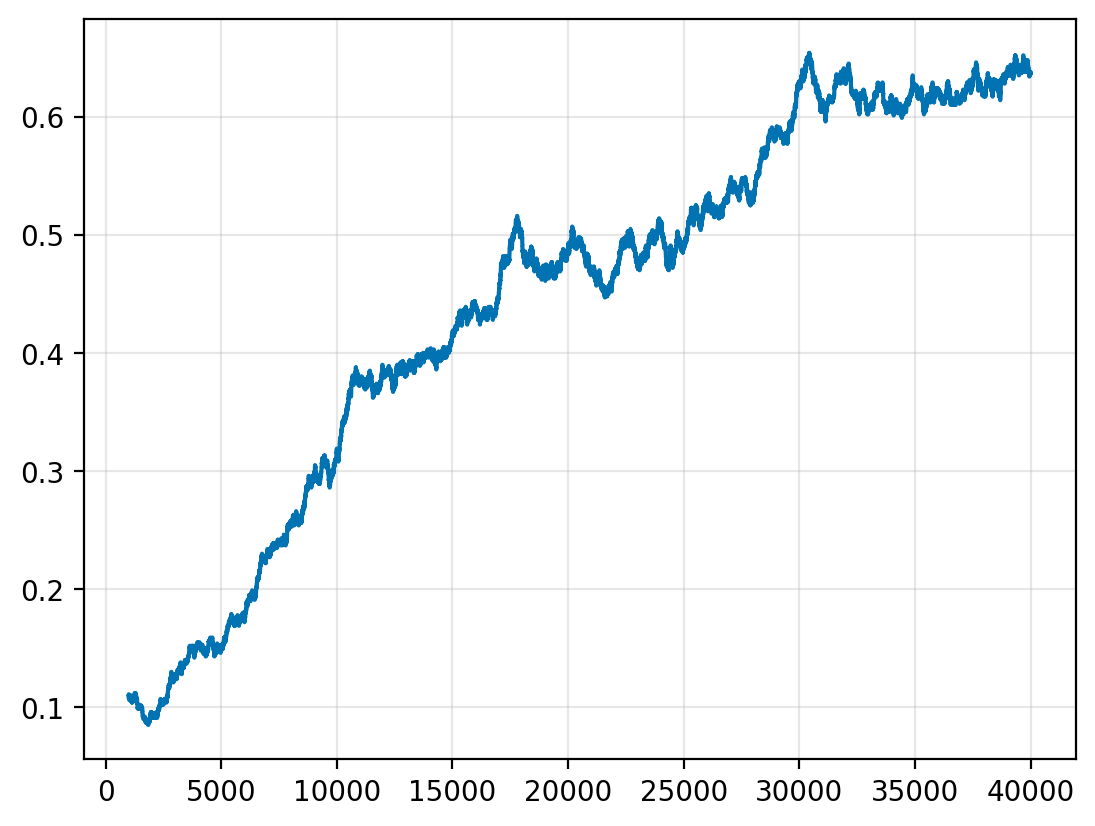

In [811]:
pd.Series(rewards_lll).rolling(1000).mean().plot(label=r"$\epsilon$-greedy")
plt.grid(alpha=0.3)

{'flores': (40000,), 'lofi': (40000,), 'lrkf': (40000,), 'ogd': (40000,)}


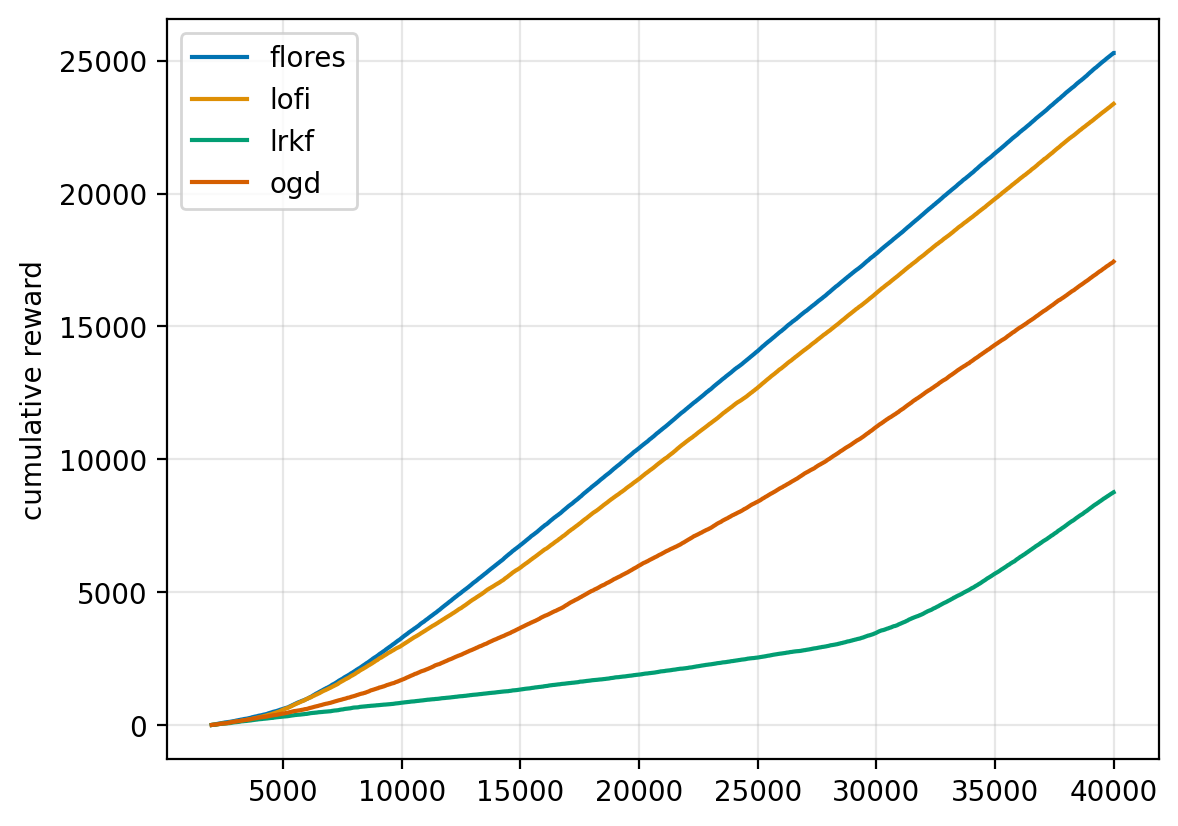

In [812]:
rewards_eps = {
    "flores": rewards_flores,
    "lofi": rewards_lofi,
    "lrkf": rewards_lrkf,
    "ogd": rewards_lll,
}
print(jax.tree.map(jnp.shape, rewards_eps))

rewards_eps = jax.tree.map(np.array, rewards_eps)
rewards_eps = pd.DataFrame(rewards_eps)
# rewards_eps.rolling(1000).mean().plot()
(rewards_eps).iloc[2_000:].cumsum().plot()
plt.ylabel("cumulative reward")
plt.grid(alpha=0.3)

## Neural bandits: partial information setting (Thompson sampling)

## LLA-TS

In [23]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    yhat = agent.sample_predictive(key_take, bel, context[..., None])
    action = yhat.argmax()
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = jnp.concat([jnp.array([action]), context.ravel()])
    # X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [487]:
def lossfn(params, counter, x, y, apply_fn, noise=0.1):
    x = jnp.atleast_2d(x)
    action = x[:, 0].astype(int)
    x = x[:, 1:].reshape(-1, 28, 28, 1)
    res = apply_fn(params, x)

    params_flat, _ = ravel_pytree(params)
    
    yhat = jnp.take_along_axis(jnp.atleast_2d(res), action[:, None], axis=-1).squeeze()
    yhat = jax.nn.sigmoid(yhat)
    y = y.squeeze()

    log_likelihood = y * jnp.log(yhat) + (1 - y) * jnp.log1p(-yhat)
    log_likelihood = (log_likelihood * counter).sum() / counter.sum()
    return -log_likelihood #+ 0.1 * jnp.power(params_flat, 2).mean()


learning_rate = 1e-4
buffer_size = 1
n_inner = 5
agent = FifoLaplaceDiag(
    mean_fn_ll,
    lossfn,
    # tx=optax.adam(learning_rate),
    tx=optax.contrib.muon(learning_rate),
    buffer_size=buffer_size,
    # dim_features=(28, 28, 1),
    dim_features = 28 ** 2 + 1,
    dim_output=1,
    n_inner=n_inner,
)

In [488]:
%%time
bel_init = agent.init_bel(params_init)
u_init = (bel_init, context_init, state_init)

state_final, (actions, rewards_lll) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lll = jax.block_until_ready((rewards_lll + 1) / 2)

CPU times: user 7.59 s, sys: 302 ms, total: 7.9 s
Wall time: 38.8 s


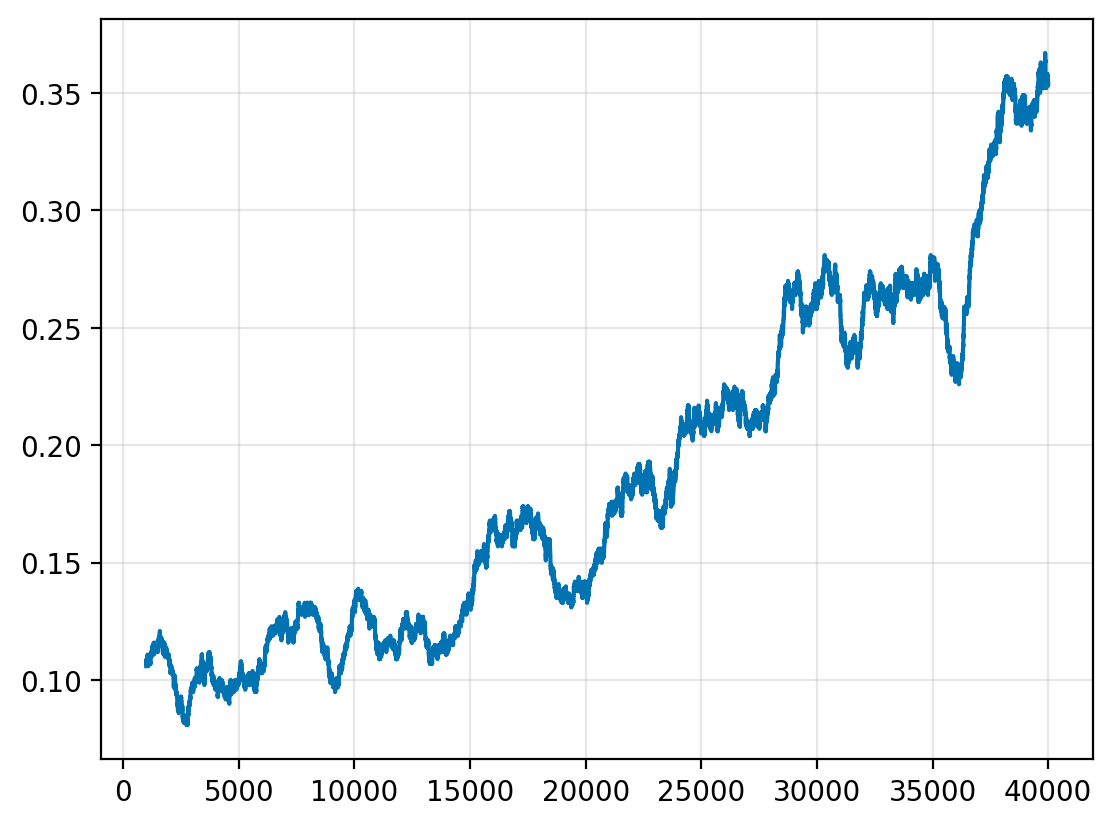

In [489]:
pd.Series(rewards_lll).rolling(1000).mean().plot(label=r"$\epsilon$-greedy")
plt.grid(alpha=0.3)

## Flores

In [143]:
from tqdm import tqdm

In [144]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        return eta


def cov_fn(eta, eps=1e-4):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [164]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    yhat = agent.sample_predictive(key_take, bel, context[..., None])
    action = yhat.argmax()
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [162]:
results = {}
ranks = [1, 5, 10, 20, 30, 40, 50]
ranks = [50]
colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))

for rank in tqdm(ranks):
    agent = flores.LowRankLastLayer(
        mean_fn,
        cov_fn,
        rank=rank,
        dynamics_hidden=1e-6,
        dynamics_last=1e-6
    )
    
    bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=0.1, cov_last=0.1)
    u_init = (bel_init, context_init, state_init)
    
    (bel_final, *_), (actions, rewards_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
    rewards_ts = jax.block_until_ready((rewards_ts + 1) / 2)
    results[rank] = np.array(rewards_ts)

  0%|                                                                                                                                           | 0/1 [00:00<?, ?it/s]

> /tmp/ipykernel_1598189/2616271541.py(10)step()
      8     yhat = agent.sample_predictive(key_take, bel, context[..., None])
      9     import pdb; pdb.set_trace()
---> 10     action = yhat.argmax()
     11 
     12     # Obtain reward



ipdb>  c


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.04s/it]


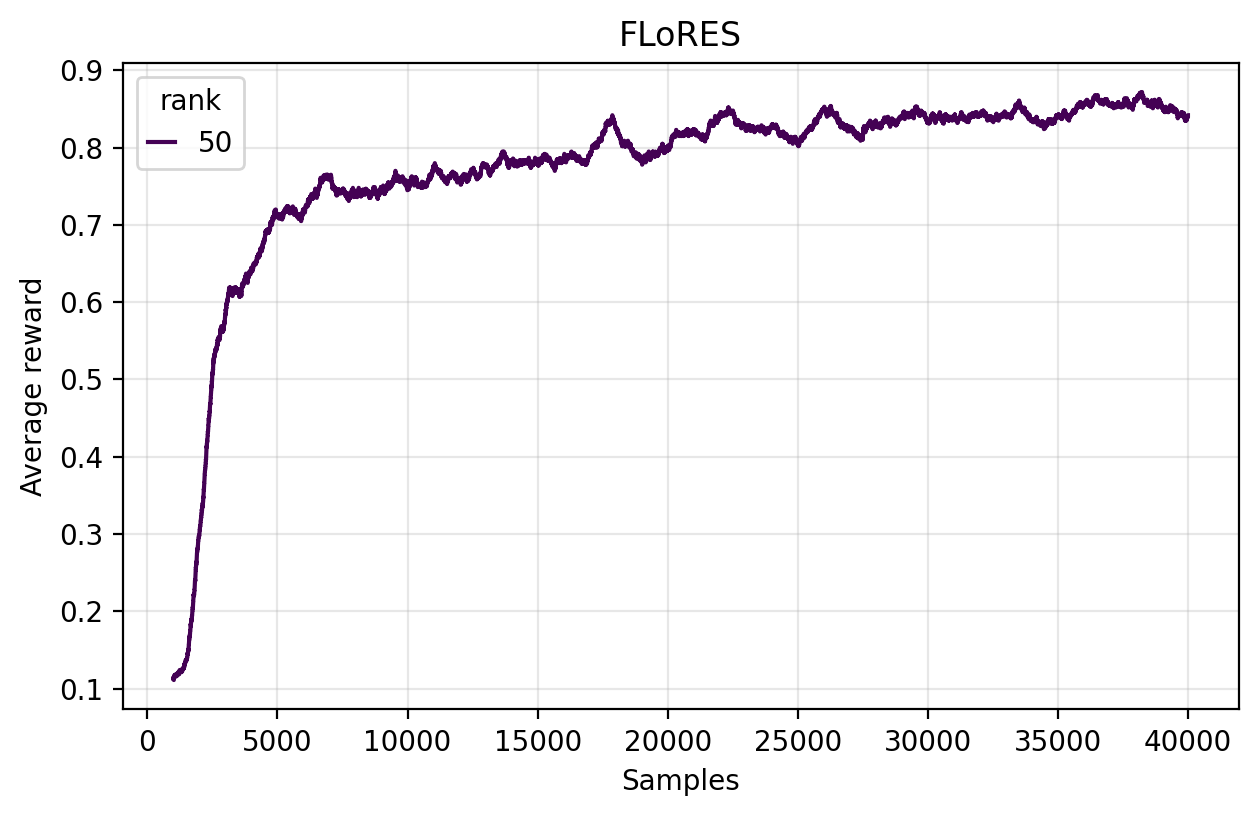

In [163]:
fig, ax = plt.subplots(figsize=(7.2, 4.2))
# colors = sns.color_palette(palette="viridis", n_colors=len(ranks))
pd.DataFrame(results).rolling(window).mean().plot(color=colors, ax=ax)
plt.ylabel("Average reward")
plt.xlabel("Samples")
plt.legend(handlelength=1, title="rank", ncol=2)
plt.title("FLoRES")
plt.grid(alpha=0.3)

## LRKF

In [154]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf

In [165]:
results_lrkf = {}
# ranks = [0, 1, 5, 10, 20, 30, 40, 50]
ranks = [50]
colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))

for rank in tqdm(ranks):
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        partial(cov_fn, eps=0.01),
        rank=rank,
        dynamics_covariance=1e-6
    )
    
    bel_init = agent.init_bel(params_init, low_rank_diag=True, cov=1.0)
    u_init = (bel_init, context_init, state_init)
    
    (bel_final, *_), (actions, rewards_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
    rewards_ts = jax.block_until_ready((rewards_ts + 1) / 2)
    results_lrkf[rank] = np.array(rewards_ts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.55s/it]


In [166]:
bel_final

LowRankState(mean=Array([-10.29266   ,  -8.639182  ,  -9.129837  , ...,   0.01827832,
         0.04593476,  -0.0166996 ], dtype=float32), low_rank=Array([[ 2.9667107e-02,  1.7947425e-03,  1.1627702e-02, ...,
         2.4730411e-09, -1.1101853e-09, -9.6173680e-10],
       [-8.9280277e-02,  1.8473357e-03, -1.1975628e-03, ...,
        -1.4349694e-09,  7.0346523e-10, -8.8368098e-11],
       [ 5.7710499e-02,  1.6684298e-04, -1.2076166e-02, ...,
        -5.9972322e-10,  8.7717961e-10, -1.0930702e-10],
       ...,
       [-6.5496067e-07, -6.3147592e-05, -4.0658888e-05, ...,
        -3.5465990e-07,  9.1082853e-07, -2.8572710e-08],
       [ 1.0335895e-05,  2.4998371e-05, -1.9335754e-04, ...,
         1.2106945e-07,  2.3038860e-08, -4.5395581e-08],
       [-1.2970648e-06,  2.9667228e-05,  1.9601773e-04, ...,
        -4.8016074e-07,  3.5108915e-08,  3.0935670e-08]], dtype=float32))

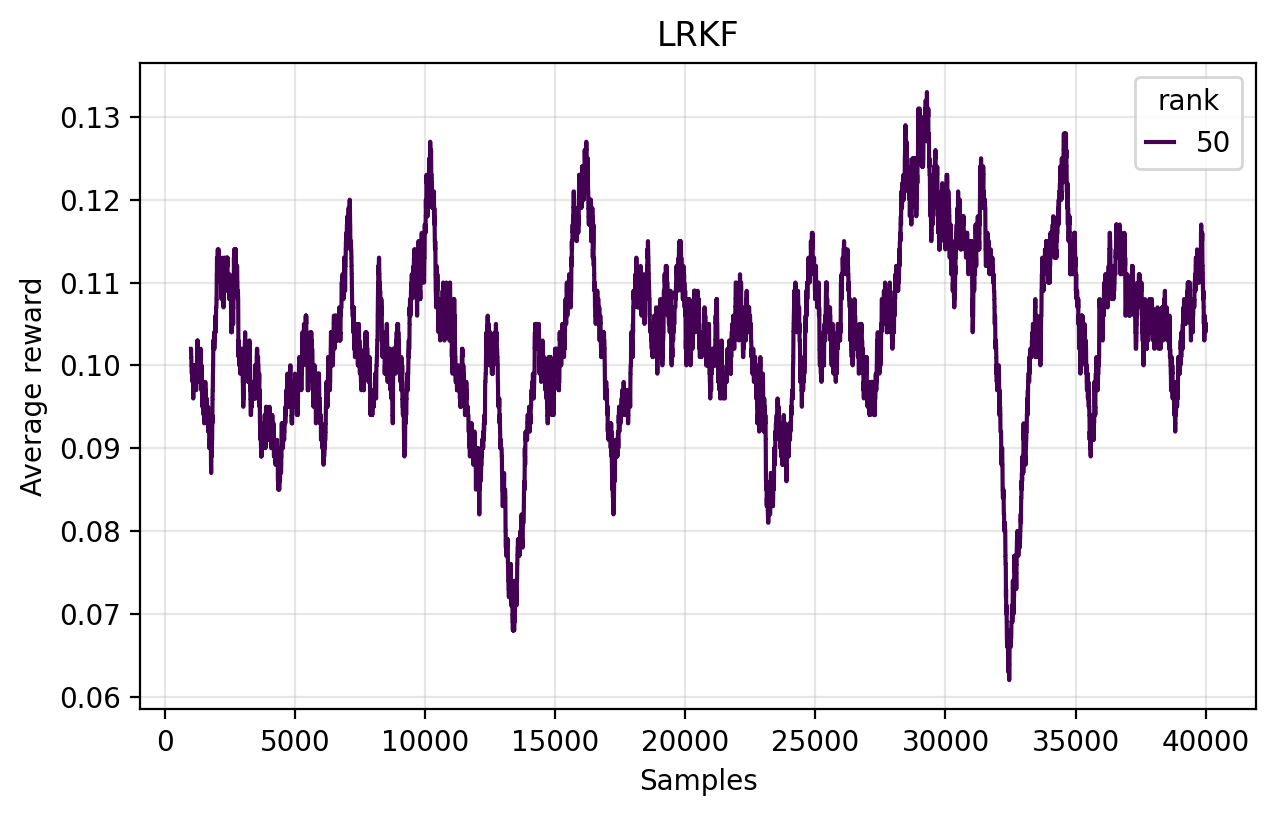

In [167]:
fig, ax = plt.subplots(figsize=(7.2, 4.2))
pd.DataFrame(results_lrkf).rolling(window).mean().plot(color=colors, ax=ax)
plt.ylabel("Average reward")
plt.xlabel("Samples")
plt.legend(handlelength=1, title="rank", ncol=2)
plt.title("LRKF")
plt.grid(alpha=0.3)

## LoFi

In [111]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        mean = jax.nn.softmax(eta)
        return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(jnp.atleast_1d(eta))
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [112]:
from rebayes_mini.methods import low_rank_filter as lofi

In [116]:
results_lofi = {}
ranks = [0, 1, 5, 10, 20, 30, 40, 50]
colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))

for rank in tqdm(ranks):
    agent = lofi.LowRankPrecisionFilter(
        mean_fn,
        cov_fn,
        rank=rank,
        dynamics_covariance=1e-6
    )
    
    bel_init = agent.init_bel(params_init, cov=jnp.exp(-8))
    u_init = (bel_init, context_init, state_init)
    
    (bel_final, *_), (actions, rewards_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
    rewards_ts = jax.block_until_ready((rewards_ts + 1) / 2)
    results_lofi[rank] = np.array(rewards_ts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:41<00:00, 20.15s/it]


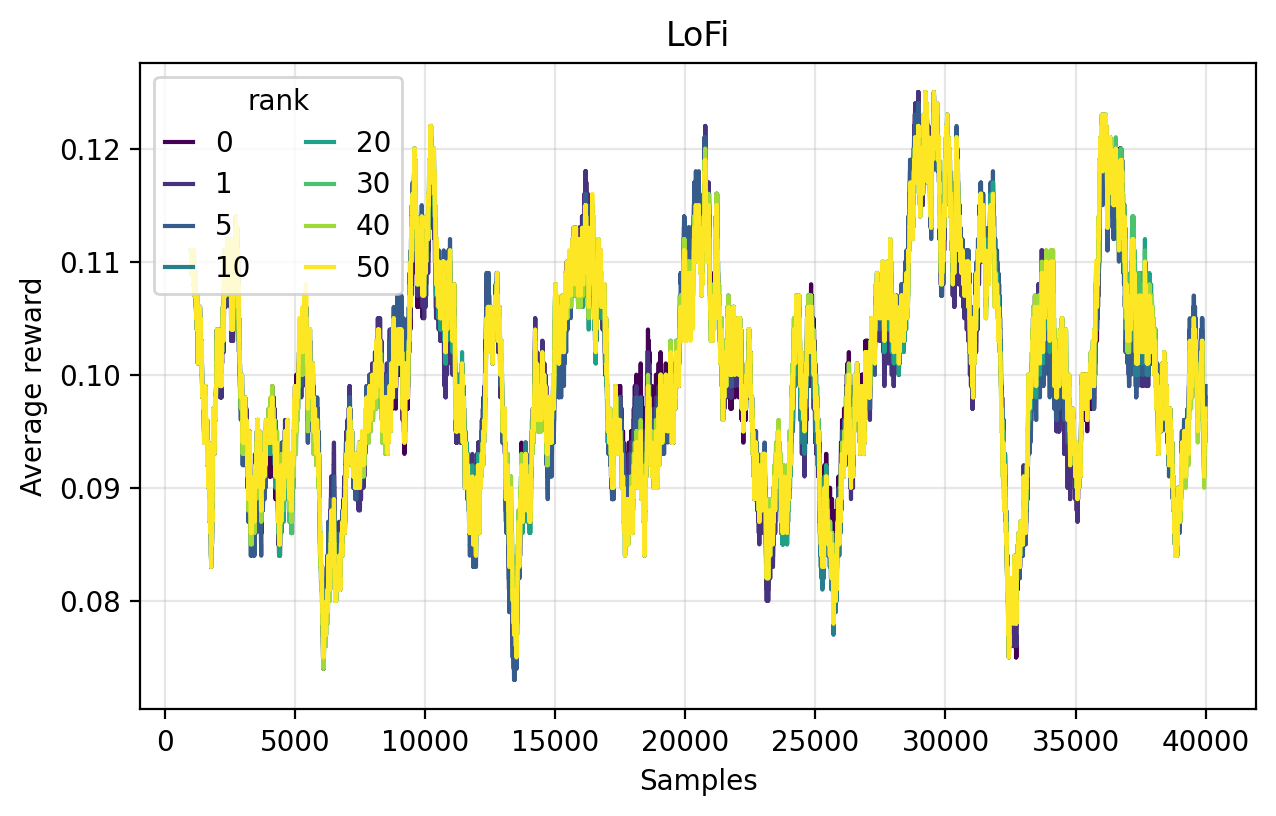

In [117]:
fig, ax = plt.subplots(figsize=(7.2, 4.2))
pd.DataFrame(results_lofi).rolling(window).mean().plot(color=colors, ax=ax)
plt.ylabel("Average reward")
plt.xlabel("Samples")
plt.legend(handlelength=1, title="rank", ncol=2)
plt.title("LoFi")
plt.grid(alpha=0.3)

## TS LoFi

In [399]:
from rebayes_mini.methods import low_rank_filter as lofi

In [400]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        mean = jax.nn.softmax(eta)
        return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(jnp.atleast_1d(eta))
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [401]:
%%time
dynamics = 1e-3
agent = lofi.LowRankPrecisionFilter(
    mean_fn, cov_fn, dynamics_covariance=dynamics, rank=50
)

bel_init = agent.init_bel(params_init, cov=1.0)
u_init = (bel_init, context_init, state_init)

(bel_final, _, _), (actions, rewards_lofi) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lofi = jax.block_until_ready((rewards_lofi + 1) / 2)

CPU times: user 17.3 s, sys: 342 ms, total: 17.6 s
Wall time: 37.3 s


In [402]:
bel_final.mean

Array([-0.09022668, -0.33926195, -0.3095262 , ..., -0.02665663,
       -0.08946812, -0.08496626], dtype=float32)

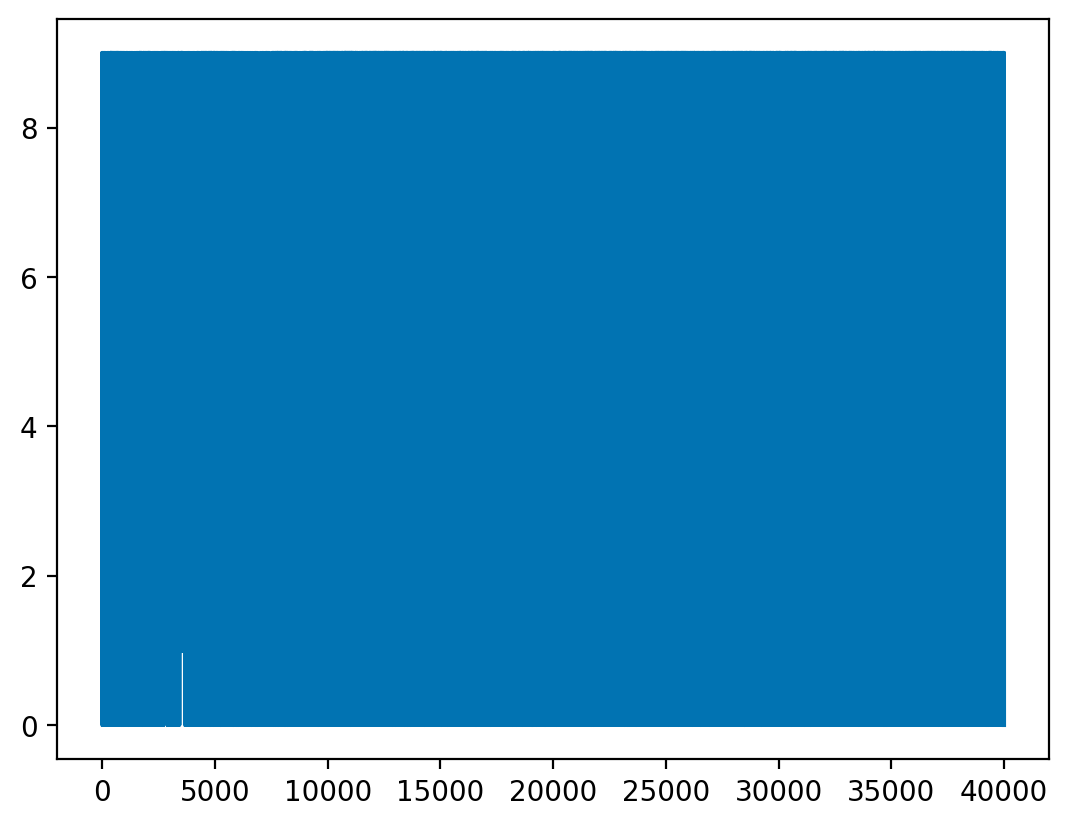

In [403]:
plt.plot(actions)

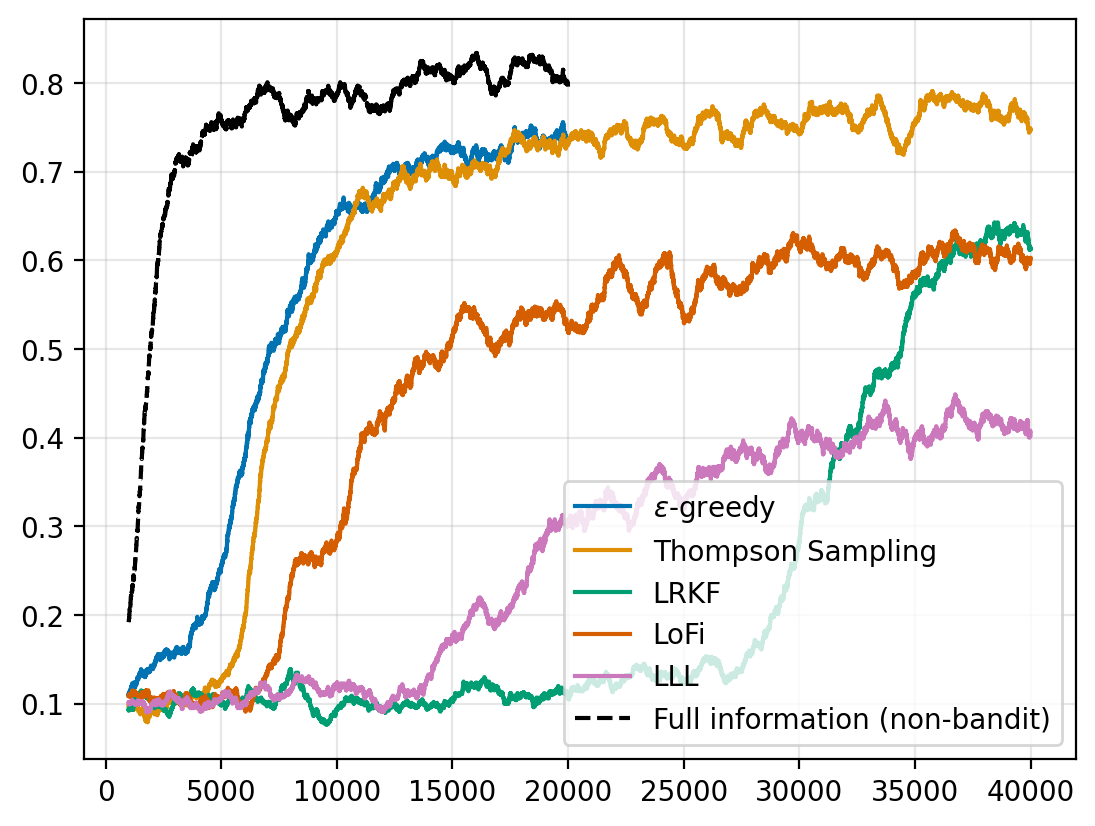

In [405]:
window = 1000
pd.Series(rewards_eps).rolling(window).mean().plot(label=r"$\epsilon$-greedy")
pd.Series(rewards_ts).rolling(window).mean().plot(label="Thompson Sampling")
pd.Series(rewards_lrkf).rolling(window).mean().plot(label="LRKF")
pd.Series(rewards_lofi).rolling(window).mean().plot(label="LoFi")
pd.Series(rewards_lll).rolling(window).mean().plot(label="LLL")
pd.Series(rewards_fullinfo).rolling(window).mean().plot(label="Full information (non-bandit)", c="black", linestyle="--")
plt.legend()
plt.grid(alpha=0.3)

## LRKF - TS

In [406]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        mean = jax.nn.softmax(eta)
        return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [439]:
%%time
dynamics = 1e-4
agent = lrkf.LowRankCovarianceFilter(
    mean_fn, cov_fn, dynamics_covariance=dynamics, rank=50
)

bel_init = agent.init_bel(params_init, cov=1.0, low_rank_diag=False)
u_init = (bel_init, context_init, state_init)
steps = 40_000

(bel_final, _, _), (actions, rewards_lrkf_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lrkf_ts = jax.block_until_ready((rewards_lrkf_ts + 1) / 2)

CPU times: user 2.84 s, sys: 28.3 ms, total: 2.87 s
Wall time: 17.8 s


In [440]:
pdist = agent.predictive_density(bel_final, context[..., None])

In [441]:
pdist.sample(seed=key)

Array([ 0.07047823,  0.6384909 , -0.49898663, -0.30017623, -0.20813721,
        0.8742342 , -0.14237507,  0.33534077,  0.8354081 ,  0.11697879],      dtype=float32)

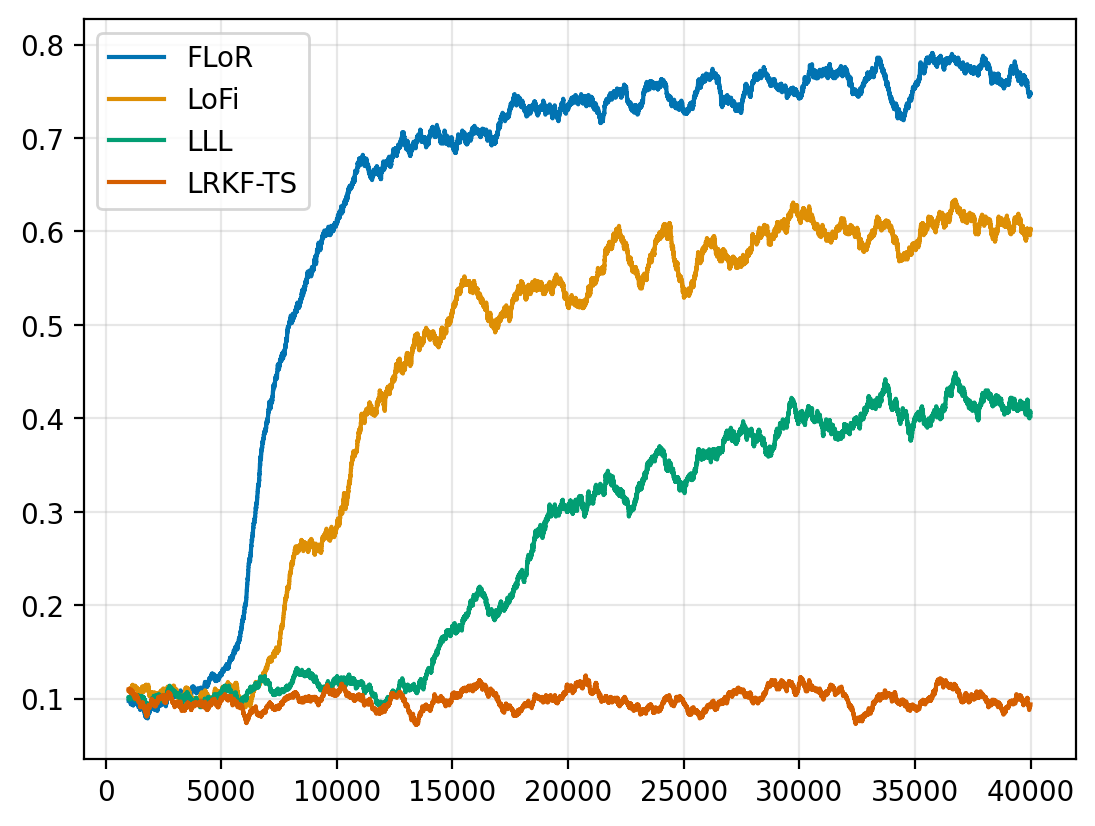

In [447]:
window = 1000
# pd.Series(rewards_fullinfo).rolling(window).mean().plot(label="Full information (non-bandit)", c="black", linestyle="--")
# pd.Series(rewards_eps).rolling(window).mean().plot(label=r"$\epsilon$-greedy")
pd.Series(rewards_ts).rolling(window).mean().plot(label="FLoR")
# pd.Series(rewards_lrkf).rolling(window).mean().plot(label="LRKF")
pd.Series(rewards_lofi).rolling(window).mean().plot(label="LoFi")
pd.Series(rewards_lll).rolling(window).mean().plot(label="LLL")
pd.Series(rewards_lrkf_ts).rolling(window).mean().plot(label="LRKF-TS")
plt.legend()
plt.grid(alpha=0.3)